### List datasets that will be used for training with scBasset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ~/workspace/theislab/mubind-pipeline/notebooks/pipeline/01_train_n_predict/

[Errno 2] No such file or directory: '/home/ilibarra/workspace/theislab/mubind-pipeline/notebooks/pipeline/01_train_n_predict/'
/home/ilibarra/jupyter


/home/ilibarra/miniconda3/envs/mubind/lib/python3.9/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [3]:
import mubind as mb
import utils

ModuleNotFoundError: No module named 'utils'

In [ ]:
path_by_dataset = utils.get_datasets()
for k in path_by_dataset:
    print(k)
    if k != 'pancreatic_endocrinogenesis':
        continue

organoids
gbm
noack_2022
pancreatic_endocrinogenesis
pbmc


In [ ]:
import torch
path_by_dataset = utils.get_datasets()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


move to relevant directory to execute scbasset

In [ ]:
import scanpy as sc
# only focus on the peaks defined by scBasset during training/testing
import os
import h5py
import torch.optim as topti
import warnings
import torch.utils.data as tdata
import glob
import numpy as np

In [ ]:
# prepare mubind's input based on what scBasset sees when calling its main trainer
def prepare_mubind_input(scbasset_ad_path,
                         adata,
                         k,
                         scbasset_split_file):
    species = 'hg38' if (k != 'noack_2022' and k != 'pancreatic_endocrinogenesis') else 'mm10'
    gen_path = '/mnt/c/Users/IgnacioIbarra/Dropbox/annotations/%s/genome/%s.fa' % (species, species)

    ad_scbasset = sc.read_h5ad(scbasset_ad_path)
    list(map(os.path.exists, [scbasset_split_file, scbasset_ad_path]))

    # csr matrices
    with h5py.File(scbasset_split_file, 'r') as hf:
        train_ids = hf['train_ids'][:]
        val_ids = hf['val_ids'][:]
        test_ids = hf['test_ids'][:]


    # print(adata.var)

    sep = '-' if k != 'gbm' else ':'
    adata.var['chr'] = np.where(adata.var_names.str.contains(':'),
                                adata.var_names.str.split(':').str[0],
                                adata.var_names.str.split('-').str[0])
    adata.var['chr'] = np.where(~adata.var['chr'].str.contains('chr'), 'chr', '') + adata.var['chr']

    colon_found = adata.var_names.str.contains(':').any()
    colon_found
    if colon_found:
        adata.var['start'] =   adata.var_names.str.split(':').str[1].str.split('-').str[0]
        adata.var['end'] = adata.var_names.str.split(':').str[1].str.split('-').str[1]
    else:
        adata.var['start'] = adata.var_names.str.split('-').str[1]
        adata.var['end'] = adata.var_names.str.split('-').str[2]
        
    # print(adata.var[['chr', 'start', 'end']])

    adata.var['seq_length'] = adata.var['end'].astype(int) - adata.var['start'].astype(int) + 1
    adata.var['k_summit'] = adata.var['chr'] + ':' + adata.var['start'] + '-' + adata.var['end']

    adata_train = adata[:,ad_scbasset.var_names[train_ids]].copy()
    adata_test = adata[:,ad_scbasset.var_names[test_ids]].copy()
    adata.shape, adata_train.shape, adata_test.shape


    n_seqs = None # None

    print('preparing sequences train...')
    seqs_train = mb.bindome.tl.get_sequences_from_bed(adata_train.var[['chr', 'start', 'end']].head(n_seqs),
                                                    gen_path=gen_path,
                                                    uppercase=True)
                                                # gen_path='../../../annotations/dm6/genome/dm6.fa')
    keys_train = set([s[0] for s in seqs_train])
    adata_train = adata_train[:,adata_train.var['k_summit'].isin(keys_train)]


    print('preparing sequences test...')
    seqs_test = mb.bindome.tl.get_sequences_from_bed(adata_test.var[['chr', 'start', 'end']].head(n_seqs),
                                                    gen_path=gen_path,
                                                    uppercase=True)
                                                # gen_path='../../../annotations/dm6/genome/dm6.fa')
    keys_test = set([s[0] for s in seqs_test])
    adata_test = adata_test[:,adata_test.var['k_summit'].isin(keys_test)]

    print(adata_train.shape, adata_test.shape)

    print('sum of reads', adata_train.X.sum())
    assert adata_train.X.sum() > 0

    df_train = utils.prepare_df(seqs_train, adata_train)
    df_test = utils.prepare_df(seqs_test, adata_test)

    df_train.shape, df_test.shape

    dataset_train = mb.datasets.SelexDataset(df_train,
                                            n_rounds=df_train.shape[1],
                                            enr_series=False)
    train = tdata.DataLoader(dataset=dataset_train,
                            batch_size=512,
                            shuffle=True)
    dataset_test = mb.datasets.SelexDataset(df_train,
                                            n_rounds=df_train.shape[1],
                                            enr_series=False)
    test = tdata.DataLoader(dataset=dataset_test,
                            batch_size=512,
                            shuffle=False)
    
    return adata_train, train, test

In [ ]:
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = 'annotations'

In [ ]:
path_by_dataset[k]

'/mnt/f/workspace/theislab/mubind/data/pbmc/*/processed_laura_2023_obs*_var*.h5ad'

{'organoids': '/mnt/f/workspace/theislab/mubind/data/organoids_treutlein_dataset/RNA_ATAC_metacells_sce_peaks_obs2000_var4000.h5ad',
 'gbm': '/mnt/f/workspace/theislab/mubind/data/gbm_multiome_scdori/23_01_23_atac_compressed_n1000.h5ad',
 'noack_2022': '/mnt/f/workspace/theislab/mubind/data/noack_2022/*/merged_scATAC_integrated_cicero_faye_chong_obs*_var*.h5ad',
 'pancreatic_endocrinogenesis': '/mnt/f/workspace/theislab/mubind/data/pancreatic_endocrinogenesis/*/pancreas_multiome_2022_processed_atac_obs*_var*.h5ad',
 'pbmc': '/mnt/f/workspace/theislab/mubind/data/pbmc/*/processed_laura_2023_obs*_var*.h5ad'}

In [ ]:
import pandas as pd
ad_paths = []
for k in path_by_dataset:
    ad_paths += [ad_path for ad_path in glob.glob(path_by_dataset[k]) if 'obs' in ad_path]
n_obs = [f.split('_')[-2].replace('obs', '') for f in ad_paths]
n_obs

queries = pd.DataFrame()
queries['n_obs'] = n_obs
queries['path'] = ad_paths

queries['n_obs'] = np.where(queries['n_obs'] == 'ALL', 100000, queries['n_obs'])
queries['n_obs'] = queries['n_obs'].astype(int)


/mnt/f/workspace/theislab/mubind/data/pancreatic_endocrinogenesis/episcanpy/pancreas_multiome_2022_processed_atac_obs100_var300.h5ad
pbmc (100, 369)
False /mnt/f/workspace/theislab/mubind/data/pancreatic_endocrinogenesis/episcanpy/mubind_output/obs100/pwms/model.pt
False /mnt/f/workspace/theislab/mubind/data/pancreatic_endocrinogenesis/episcanpy/mubind_output/obs100/pwms/model_1.pt
preparing sequences train...
/tmp/tmpm894vhd0
genome hg19 False
/mnt/c/Users/IgnacioIbarra/Dropbox/annotations/hg38/genome/hg38.fa
True /mnt/c/Users/IgnacioIbarra/Dropbox/annotations/hg38/genome/hg38.fa
running bedtools...
['bedtools', 'getfasta', '-fi', '/mnt/c/Users/IgnacioIbarra/Dropbox/annotations/hg38/genome/hg38.fa', '-bed', '/tmp/tmpm894vhd0', '-fo', '/tmp/tmpgk9au5z0']
bedtools getfasta -fi /mnt/c/Users/IgnacioIbarra/Dropbox/annotations/hg38/genome/hg38.fa -bed /tmp/tmpm894vhd0 -fo /tmp/tmpgk9au5z0


Feature (chr15:102279025-102279932) beyond the length of chr15 size (101991189 bp).  Skipping.
Feature (chr15:103304875-103305793) beyond the length of chr15 size (101991189 bp).  Skipping.
Feature (chr16:91931149-91932053) beyond the length of chr16 size (90338345 bp).  Skipping.
Feature (chr18:82717335-82718240) beyond the length of chr18 size (80373285 bp).  Skipping.
Feature (chr19:60226121-60227035) beyond the length of chr19 size (58617616 bp).  Skipping.
Feature (chrX:159255242-159256134) beyond the length of chrX size (156040895 bp).  Skipping.
Feature (chr16:91010774-91011726) beyond the length of chr16 size (90338345 bp).  Skipping.


preparing sequences test...
/tmp/tmpn5b86qh2
genome hg19 False
/mnt/c/Users/IgnacioIbarra/Dropbox/annotations/hg38/genome/hg38.fa
True /mnt/c/Users/IgnacioIbarra/Dropbox/annotations/hg38/genome/hg38.fa
running bedtools...
['bedtools', 'getfasta', '-fi', '/mnt/c/Users/IgnacioIbarra/Dropbox/annotations/hg38/genome/hg38.fa', '-bed', '/tmp/tmpn5b86qh2', '-fo', '/tmp/tmpx06ttop2']
bedtools getfasta -fi /mnt/c/Users/IgnacioIbarra/Dropbox/annotations/hg38/genome/hg38.fa -bed /tmp/tmpn5b86qh2 -fo /tmp/tmpx06ttop2
(100, 327) (100, 17)
sum of reads 25343.0
(327, 101)
# cells 100
# peaks 327
selected (327, 100)
(17, 101)
# cells 100
# peaks 17
selected (17, 100)
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,

Feature (chr13:117315086-117315923) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr14:118282646-118283551) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr17:83937177-83937968) beyond the length of chr17 size (83257441 bp).  Skipping.
Feature (chr19:58879793-58880578) beyond the length of chr19 size (58617616 bp).  Skipping.
Feature (chrX:160856362-160857235) beyond the length of chrX size (156040895 bp).  Skipping.


(100, 266) (100, 15)
sum of reads 1860.0
(266, 101)
# cells 100
# peaks 266
selected (231, 100)
(15, 101)
# cells 100
# peaks 15
selected (13, 100)
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,

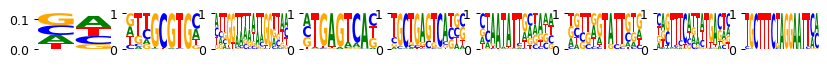

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [03:55<00:00, 15.69s/it]


Current time: 2024-06-05 01:26:01.196913
	Loss: 267.909 , R2: 0.068
	Training time (model/function): (235.329s / 235.329s)
		per epoch (model/function): (16.809s/ 16.809s)
		per 1k samples: 51.721s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9998439794291893, pvalue=1.3182763122274082e-173))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 50

### next filter to optimize 50 

FREEZING KERNELS
optimizing feature type mono
next kernels {50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [03:44<00:00, 14.98s/it]


Current time: 2024-06-05 01:30:09.395081
	Loss: 259.332 , R2: 0.081
	Training time (model/function): (460.094s / 224.765s)
		per epoch (model/function): (32.864s/ 16.055s)
		per 1k samples: 49.399s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9998439794291893, pvalue=1.3182763122274082e-173))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [04:24<00:00, 17.62s/it]


Current time: 2024-06-05 01:34:54.237335
	Loss: 246.248 , R2: 0.081
	Training time (model/function): (724.432s / 264.337s)
		per epoch (model/function): (51.745s/ 18.881s)
		per 1k samples: 58.096s
best loss 246.248
last five r2 values, by sequential filter optimization: ['0.081']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9998439794291893, pvalue=1.3182763122274082e-173))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 100

### next filter to optimize 100 

FREEZING KERNELS
optimizing feature type mono
next kernels {128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [03:40<00:00, 14.72s/it]


Current time: 2024-06-05 01:39:17.412465
	Loss: 240.417 , R2: 0.088
	Training time (model/function): (945.299s / 220.867s)
		per epoch (model/function): (67.521s/ 15.776s)
		per 1k samples: 48.542s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9998439794291893, pvalue=1.3182763122274082e-173))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [04:02<00:00, 16.17s/it]


Current time: 2024-06-05 01:43:42.258512
	Loss: 227.093 , R2: 0.088
	Training time (model/function): (1187.922s / 242.624s)
		per epoch (model/function): (84.852s/ 17.330s)
		per 1k samples: 53.324s
best loss 227.093
last five r2 values, by sequential filter optimization: ['0.081', '0.088']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9998439794291893, pvalue=1.3182763122274082e-173))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 150

### next filter to optimize 150 

FREEZING KERNELS
optimizing feature type mono
next kernels {150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir wei

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [03:43<00:00, 14.89s/it]


Current time: 2024-06-05 01:48:11.152913
	Loss: 221.720 , R2: 0.093
	Training time (model/function): (1411.294s / 223.372s)
		per epoch (model/function): (100.807s/ 15.955s)
		per 1k samples: 49.093s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9998439794291893, pvalue=1.3182763122274082e-173))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [04:11<00:00, 16.76s/it]


Current time: 2024-06-05 01:52:45.774065
	Loss: 209.348 , R2: 0.093
	Training time (model/function): (1662.686s / 251.392s)
		per epoch (model/function): (118.763s/ 17.957s)
		per 1k samples: 55.251s
best loss 209.348
last five r2 values, by sequential filter optimization: ['0.081', '0.088', '0.093']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9998439794291893, pvalue=1.3182763122274082e-173))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 200

### next filter to optimize 200 

FREEZING KERNELS
optimizing feature type mono
next kernels {200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [03:44<00:00, 14.98s/it]


Current time: 2024-06-05 01:57:15.948212
	Loss: 205.266 , R2: 0.095
	Training time (model/function): (1887.343s / 224.657s)
		per epoch (model/function): (134.810s/ 16.047s)
		per 1k samples: 49.375s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9998439794291893, pvalue=1.3182763122274082e-173))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [04:04<00:00, 16.29s/it]


Current time: 2024-06-05 02:01:42.425118
	Loss: 194.360 , R2: 0.095
	Training time (model/function): (2131.767s / 244.424s)
		per epoch (model/function): (152.269s/ 17.459s)
		per 1k samples: 53.719s
best loss 194.360
last five r2 values, by sequential filter optimization: ['0.081', '0.088', '0.093', '0.095']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9998439794291893, pvalue=1.3182763122274082e-173))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 250

### next filter to optimize 250 

FREEZING KERNELS
optimizing feature type mono
next kernels {256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 250, 251, 252, 253, 254, 255}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weigh

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [03:44<00:00, 14.95s/it]


Current time: 2024-06-05 02:06:10.972634
	Loss: 191.802 , R2: 0.097
	Training time (model/function): (2355.957s / 224.190s)
		per epoch (model/function): (168.283s/ 16.014s)
		per 1k samples: 49.273s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9998439794291893, pvalue=1.3182763122274082e-173))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [03:57<00:00, 15.83s/it]


Current time: 2024-06-05 02:10:30.720679
	Loss: 182.385 , R2: 0.097
	Training time (model/function): (2593.477s / 237.520s)
		per epoch (model/function): (185.248s/ 16.966s)
		per 1k samples: 52.202s
best loss 182.385
last five r2 values, by sequential filter optimization: ['0.081', '0.088', '0.093', '0.095', '0.097']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9998439794291893, pvalue=1.3182763122274082e-173))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 2593.4768364429474s
Time per epoch (total): 0.596 s
saving model...
True /mnt/f/workspace/theislab/mubind/data/pbmc/episcanpy/mubind_output/obs100/pwms/running_time.pkl
/mnt/f/workspace/theislab/mubind/data/pbmc/random/processed_laura_2023_obs100_var300.h5ad
pbmc (100, 300)
False /mnt/f/workspace/theislab/mubind/data/pbmc/random/mubind_output/obs100/pwms/model.pt
False /mnt/f/workspace/theislab/mubind/data/pbmc/random/mubin

Feature (chr14:116870514-116871427) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr16:90340935-90341809) beyond the length of chr16 size (90338345 bp).  Skipping.
Feature (chr16:91330907-91331750) beyond the length of chr16 size (90338345 bp).  Skipping.
Feature (chr16:93008921-93009760) beyond the length of chr16 size (90338345 bp).  Skipping.
Feature (chr16:93369351-93370259) beyond the length of chr16 size (90338345 bp).  Skipping.
Feature (chr17:84540534-84541080) beyond the length of chr17 size (83257441 bp).  Skipping.
Feature (chr17:85571917-85572443) beyond the length of chr17 size (83257441 bp).  Skipping.
Feature (chr17:88558130-88559015) beyond the length of chr17 size (83257441 bp).  Skipping.
Feature (chr18:81397194-81398072) beyond the length of chr18 size (80373285 bp).  Skipping.
Feature (chr18:82837804-82838259) beyond the length of chr18 size (80373285 bp).  Skipping.
Feature (chr18:84784756-84785629) beyond the length of chr18 size (80373285 b

preparing sequences test...
/tmp/tmpvp9wseiz
genome hg19 False
/mnt/c/Users/IgnacioIbarra/Dropbox/annotations/hg38/genome/hg38.fa
True /mnt/c/Users/IgnacioIbarra/Dropbox/annotations/hg38/genome/hg38.fa
running bedtools...
['bedtools', 'getfasta', '-fi', '/mnt/c/Users/IgnacioIbarra/Dropbox/annotations/hg38/genome/hg38.fa', '-bed', '/tmp/tmpvp9wseiz', '-fo', '/tmp/tmpche3wkh2']
bedtools getfasta -fi /mnt/c/Users/IgnacioIbarra/Dropbox/annotations/hg38/genome/hg38.fa -bed /tmp/tmpvp9wseiz -fo /tmp/tmpche3wkh2
(200, 528) (200, 28)
sum of reads 9033.0
(528, 201)
# cells 200
# peaks 528
selected (502, 200)
(28, 201)
# cells 200
# peaks 28
selected (27, 200)
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 

Feature (chr13:119488017-119488910) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr14:121878090-121878997) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr15:102721758-102722660) beyond the length of chr15 size (101991189 bp).  Skipping.
Feature (chr16:90810027-90810905) beyond the length of chr16 size (90338345 bp).  Skipping.
Feature (chr16:97763297-97764157) beyond the length of chr16 size (90338345 bp).  Skipping.
Feature (chr17:83350470-83351357) beyond the length of chr17 size (83257441 bp).  Skipping.
Feature (chr17:84465754-84466657) beyond the length of chr17 size (83257441 bp).  Skipping.
Feature (chr18:80707677-80708602) beyond the length of chr18 size (80373285 bp).  Skipping.
Feature (chr18:84588877-84589788) beyond the length of chr18 size (80373285 bp).  Skipping.


preparing sequences test...
/tmp/tmp8qnk1nig
genome hg19 False
/mnt/c/Users/IgnacioIbarra/Dropbox/annotations/hg38/genome/hg38.fa
True /mnt/c/Users/IgnacioIbarra/Dropbox/annotations/hg38/genome/hg38.fa
running bedtools...
['bedtools', 'getfasta', '-fi', '/mnt/c/Users/IgnacioIbarra/Dropbox/annotations/hg38/genome/hg38.fa', '-bed', '/tmp/tmp8qnk1nig', '-fo', '/tmp/tmpzv4991hh']
bedtools getfasta -fi /mnt/c/Users/IgnacioIbarra/Dropbox/annotations/hg38/genome/hg38.fa -bed /tmp/tmp8qnk1nig -fo /tmp/tmpzv4991hh
(200, 567) (200, 31)
sum of reads 90106.0
(567, 201)
# cells 200
# peaks 567
selected (567, 200)
(31, 201)
# cells 200
# peaks 31
selected (31, 200)
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,

Feature (chr13:119408725-119409719) beyond the length of chr13 size (114364328 bp).  Skipping.
Feature (chr14:115041769-115042655) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:122104543-122105449) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr14:122106704-122107546) beyond the length of chr14 size (107043718 bp).  Skipping.
Feature (chr15:102279025-102279932) beyond the length of chr15 size (101991189 bp).  Skipping.
Feature (chr15:102670633-102671518) beyond the length of chr15 size (101991189 bp).  Skipping.
Feature (chr15:102721758-102722660) beyond the length of chr15 size (101991189 bp).  Skipping.
Feature (chr15:103304875-103305793) beyond the length of chr15 size (101991189 bp).  Skipping.
Feature (chr16:90810027-90810905) beyond the length of chr16 size (90338345 bp).  Skipping.
Feature (chr16:92057738-92058674) beyond the length of chr16 size (90338345 bp).  Skipping.
Feature (chr16:93603438-93604351) beyond the length of c

preparing sequences test...
/tmp/tmp2mq15og_
genome hg19 False
/mnt/c/Users/IgnacioIbarra/Dropbox/annotations/hg38/genome/hg38.fa
True /mnt/c/Users/IgnacioIbarra/Dropbox/annotations/hg38/genome/hg38.fa
running bedtools...
['bedtools', 'getfasta', '-fi', '/mnt/c/Users/IgnacioIbarra/Dropbox/annotations/hg38/genome/hg38.fa', '-bed', '/tmp/tmp2mq15og_', '-fo', '/tmp/tmpe7p13z4h']
bedtools getfasta -fi /mnt/c/Users/IgnacioIbarra/Dropbox/annotations/hg38/genome/hg38.fa -bed /tmp/tmp2mq15og_ -fo /tmp/tmpe7p13z4h
(300, 812) (300, 46)
sum of reads 185166.0
(812, 301)
# cells 300
# peaks 812
selected (812, 300)
(46, 301)
# cells 300
# peaks 46
selected (46, 300)
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15

In [29]:
res = []
import numpy as np
import pickle
n_epochs_intercept = 15
n_epochs_kernel = 15
overwrite = False
overwrite_train = False
log_each=75
n_unfreeze_kernels=50

n_missing = 0

for ri, r in queries.sort_values('n_obs').iterrows():
# for k in path_by_dataset:
#     for ad_path in glob.glob(path_by_dataset[k]):
    # if not '_obs100_' in ad_path: #  and not '_obs200_' in ad_path: #  or not '/random/' in ad_path:
    #     continue

    ad_path = r['path']

    n_cells = ad_path.split('_')[-2]
    print(ad_path)

    # assert False
    # print('reading anndata', ad_path)

    # print(ad_path)
    # continue

    adata = sc.read_h5ad(ad_path)
    print(k, adata.shape)
    # if neighbors are not present in the file, we have to include them
    if not 'neighbors' in adata.uns:
        if 'int' in str(adata.X.dtype):
            adata.X = adata.X.astype(float)
        sc.pp.neighbors(adata, method='rapids')

    scbasset_split_file = os.path.join(os.path.dirname(ad_path), 'scbasset_input', n_cells, 'splits.h5')
    scbasset_ad_path = os.path.join(os.path.dirname(ad_path), 'scbasset_input', n_cells, 'ad.h5ad')


    if not os.path.exists(scbasset_ad_path):
        print('ad path not found. Next')
        continue

    mubind_outdir = os.path.join(os.path.dirname(ad_path), 'mubind_output', n_cells)
    if not os.path.exists(mubind_outdir):
        os.makedirs(mubind_outdir)
    
    for use_pwms, lab in zip([True, False], ['pwms', 'denovo']):
        if lab != 'pwms':
            continue
        
        next_outdir = os.path.join(mubind_outdir, lab)
        if not os.path.exists(next_outdir):
            os.makedirs(next_outdir)
        
        model_path = os.path.join(next_outdir, 'model.pt')
        print(os.path.exists(model_path), model_path)

        model_path_logdyn_true = model_path.replace('.pt', '_1.pt')

        print(os.path.exists(model_path_logdyn_true), model_path_logdyn_true)

        # assert False
        if not os.path.exists(model_path_logdyn_true):
            n_missing += 1
    
        if not os.path.exists(model_path_logdyn_true) or overwrite:
            adata_train, train, test = prepare_mubind_input(scbasset_ad_path,
                                                            adata,
                                                            k,
                                                            scbasset_split_file)

            model_by_logdynamic = {}
            n_filters = 5 if lab == 'denovo' else 288
            opt_kernel_shift=[0, 0] + [0] * (n_filters)
            opt_kernel_length=[0, 0] + [0] * (n_filters)
            kernels=[0] + [2] + [20] * (n_filters)

            w = [10 for r in range(n_filters)]
            epochs = [n_epochs_intercept] + [n_epochs_kernel] * (n_filters + 1)
            print(epochs)
            # skip_kernels=range(5, 500) do not skip kernels
            opt_kernel_shift=[0, 0] + [0] * (n_filters)

            for optimize_log_dynamic in [False,]: #  True]: #  True]:

                # save model
                next_model_path = model_path.replace('.pt', '_%i.pt' % optimize_log_dynamic)
                print(k, next_model_path)

                if not os.path.exists(next_model_path) or overwrite_train:
                    print('')
                    print('optimize log dynamics', optimize_log_dynamic)
                    warnings.filterwarnings("ignore")

                    criterion = mb.tl.PoissonLoss()
                    # w = [r.shape[1] for r in pwms]

                    if use_pwms:
                        pwms = mb.datasets.archetypes()
                        w = [r.shape[1] for r in pwms]

                    model = mb.models.Mubind.make_model(train,
                                                        n_filters,
                                                        criterion,
                                                        kernels=[0, 2] + w,
                                                        # use_dinuc=True, dinuc_mode='full',
                                                        optimize_sym_weight=False,
                                                        optimize_exp_barrier=True,
                                                        optimize_prob_act=True,
                                                        optimize_log_dynamic=optimize_log_dynamic,
                                                        use_dinuc=False,
                                                        device=device,
                                                        log_each=log_each,
                                                        p_dropout=None, # 0.8,
                                                        adata=adata_train if optimize_log_dynamic else None,
                                                        prepare_knn=optimize_log_dynamic,
                                                        dinuc_mode=None).cuda()
                    

                    if use_pwms:
                        # initialize the reduce kernels
                        for i, mono_best in enumerate(pwms):
                            mono_best = mono_best.to_numpy()
                            if mono_best.shape[-1] == 0:
                                continue
                            # print(mono_best.shape, model.binding_modes.conv_mono[i + 1].weight.shape)
                            # print(model.binding_modes.conv_mono[i + 1].weight.device)
                            new_w = mono_best.reshape([1, 1] + list(mono_best.shape))
                            # print(i, i + 1)
                            model.binding_modes.conv_mono[i + 2].weight = torch.nn.Parameter(torch.tensor(new_w, dtype=torch.float))
                            # print(model.binding_modes.conv_mono[i + 1].weight.device)
                        # move the model a final time to the GPU
                        model = model.to(device)

                    mb.pl.set_rcParams({'figure.figsize': [15, 3], 'figure.dpi': 90})
                    mb.pl.logo(model,
                            title=False,
                            xticks=False,
                            rowspan_dinuc=0,
                            rowspan_mono=1,
                            n_rows=5,
                            n_cols=12,
                            stop_at=10   ) # n_cols=len(reduced_groups))
                        
                    mb.pl.set_rcParams({'figure.figsize': [20, 5], 'figure.dpi': 100})

                    # mb.pl.conv(model, n_cols=2)
                    import torch.nn as tnn

                    if optimize_log_dynamic:
                        model.graph_module.conn_sparse = torch.tensor(adata[adata_train.obs_names,:].obsp['connectivities'].A).to_sparse().requires_grad_(True).cuda()
                        model.graph_module.log_dynamic = tnn.Parameter(torch.rand(model.graph_module.conn_sparse.indices().shape[1])) # .cuda()
                        model = model.cuda()
                        model.graph_module.log_dynamic.shape


                    import datetime
                    t1 = datetime.datetime.now()
                    model, best_loss = model.optimize_iterative(train,
                                                                n_epochs=epochs,
                                                                show_logo=False,
                                                                use_mono=True,
                                                                use_dinuc=False,
                                                                dinuc_mode='local',
                                                                opt_kernel_shift=opt_kernel_shift,
                                                                opt_kernel_length=opt_kernel_length,
                                                                opt_one_step=True,
                                                                shift_max=1,
                                                                shift_step=1,
                                                                optimiser=topti.Adam,
                                                                n_batches=1,
                                                                n_rounds=2,
                                                                num_epochs_shift_factor=1,
                                                                r2_per_epoch=True,
                                                                kernels=kernels,
                                                                n_unfreeze_kernels=n_unfreeze_kernels,
                                                                skip_kernels=None, # skip_kernels,
                                                                exp_max=8,
                                                                early_stopping=250,
                                                                log_each=log_each,
                                                                w=20,
                                                                max_w=20) #  target_dim=train.dataset.signal.shape[1])

                    t2 = datetime.datetime.now()

                    torch.save(model, next_model_path)
                    model_by_logdynamic[optimize_log_dynamic] = model

                    print('saving model...')
                    outpath_time = os.path.join(next_outdir, 'running_time.pkl')
                    time_diff = (t2 - t1)
                    pickle.dump(time_diff, open(outpath_time, 'wb'))
                    print(os.path.exists(outpath_time), outpath_time)
                    
                else:
                    model = torch.load(next_model_path)

                roc_auc_train, roc_auc_test = utils.get_auroc(model, train), utils.get_auroc(model, test)
                auprc_train, auprc_test = utils.get_auprc(model, train), utils.get_auprc(model, test)
                res.append([k, optimize_log_dynamic, 'train', 'roc_auc', roc_auc_train])
                res.append([k, optimize_log_dynamic, 'test', 'roc_auc', roc_auc_test])
                res.append([k, optimize_log_dynamic, 'train', 'pr_auc', auprc_train])
                res.append([k, optimize_log_dynamic, 'test', 'pr_auc', auprc_test])
            
            import pandas as pd
            df = pd.DataFrame(res, columns=['dataset', 'log_dynamic', 'group', 'metric', 'value'])
            df.to_csv(model_path.replace('.pt', '.csv'))

print(n_missing)

In [ ]:
import anndata
anndata.__version__

'0.10.7'